# Segmenting Buildings using Deep Learning

In [237]:
from IPython.display import clear_output

In [238]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np

import matplotlib.pyplot as plt

from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid


import imageio
import cv2
from PIL import Image

import pandas as pd

from pycocotools.coco import COCO

import os
import sys
import time


# Loading Datasets

In [239]:
import wget
import zipfile


if not os.path.exists("./dataset.zip"):  # Check if the file exists
    url = "https://www.dropbox.com/scl/fi/u3plfspdkxpxgcqt2jvkw/dataset.zip?rlkey=z82kloxfxv5jwq8k1r91bwu38&dl=1"
    filename = wget.download(url)
if not os.path.exists("./dataset"):
    with zipfile.ZipFile("./dataset.zip", 'r') as zip_ref:
        zip_ref.extractall('dataset')

# Processing Datasets

In [353]:

HEIGHT = 32
WIDTH = 32

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((HEIGHT, WIDTH)),  # Swap HEIGHT and WIDTH here
    transforms.CenterCrop((HEIGHT, WIDTH)),  # Swap HEIGHT and WIDTH here
])

class MyDataset(Dataset):
    def __init__(self, image_folder, annotation_file):
        self.coco = COCO(annotation_file)
        self.image_folder = image_folder
        self.image_ids = self.coco.getImgIds()

    def __getitem__(self, index):
        img_id = self.image_ids[index]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_folder, img_info['file_name'])
        img = imageio.imread(img_path)
        img = transform(img)

        # Load the segmentation mask for the image
        mask = self.load_mask(img_info)
        mask = transforms.Resize((HEIGHT, WIDTH)).forward(mask)
        

        return {"images": img, "masks": mask}

    def load_mask(self, img_info):
        # Initialize a mask for all categories in the image with zeros
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

        # Load the segmentation masks for each instance in the image
        ann_ids = self.coco.getAnnIds(imgIds=img_info['id'], iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)

        for ann in anns:
            # Check if 'segmentation' is in polygon format or RLE
            if type(ann['segmentation']) == list:
                # If it's a list, assume it's polygons and convert to mask
                for seg in ann['segmentation']:
                    poly = np.array(seg).reshape((int(len(seg)/2), 2))
                    mask |= self.coco.annToMask(ann)  # Use annToMask for polygons
            else:
                # If it's not a list, treat it as RLE
                mask |= self.coco.annToMask(ann)  # Directly use RLE to create mask

        # Convert the mask to a tensor
        mask = torch.as_tensor(mask, dtype=torch.float32)  # Change dtype to float32
        mask = mask.unsqueeze(0)

        return mask

    def __len__(self):
        return len(self.image_ids)


In [354]:
dataset = MyDataset("./dataset/valid/", "./dataset/valid/_annotations.coco.json")

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


torch.Size([3, 32, 32]) torch.Size([1, 32, 32])


C:\Users\ammar\AppData\Local\Temp\ipykernel_23636\2820321857.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)


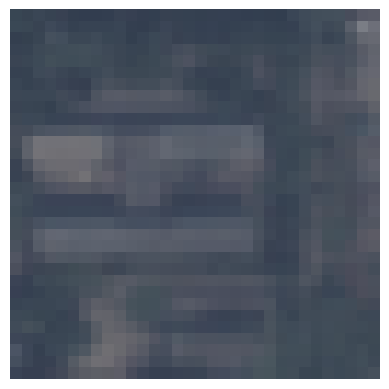

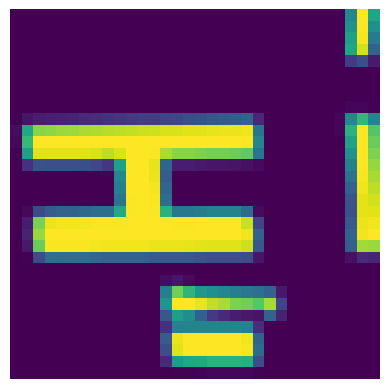

In [355]:
n = torch.randint(0, len(dataset), (1,)).item()

sample_image = dataset[n]["images"]
sample_image_mask = dataset[n]["masks"]
print(sample_image.shape, sample_image_mask.shape)

sample_image_numpy = sample_image.permute(1, 2, 0).cpu().numpy()
sample_image_mask_numpy = sample_image_mask.permute(1, 2, 0).cpu().numpy()


# Display the image
plt.imshow(sample_image_numpy)
plt.axis('off')  # Hide the axis
plt.show()

# Display the image
plt.imshow(sample_image_mask_numpy)
plt.axis('off')  # Hide the axis
plt.show()

In [356]:
batch_size = 32
shuffle = True

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [357]:
data_loader

In [358]:
batch = next(iter(data_loader))

# Extract images and masks from the batch
batch_images = batch["images"]
batch_masks = batch["masks"]

batch_size = batch_images.size(0)  # Get the batch size

print(batch_size)

C:\Users\ammar\AppData\Local\Temp\ipykernel_23636\2820321857.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)


32


# Model

## Training

In [462]:
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, rates=[6, 12, 18]):
        super(ASPP, self).__init__()
        # ASPP modules
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, bias=False, padding=rates[0], dilation=rates[0])
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, bias=False, padding=rates[1], dilation=rates[1])
        self.conv4 = nn.Conv2d(in_channels, out_channels, kernel_size=3, bias=False, padding=rates[2], dilation=rates[2])
        self.conv5 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.out_conv = nn.Conv2d(out_channels * 5, out_channels, kernel_size=1, bias=False)

        
        # BatchNorm layers
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.bn4 = nn.BatchNorm2d(out_channels)
        self.bn5 = nn.BatchNorm2d(out_channels)
        self.bn6 = nn.BatchNorm2d(out_channels)

        
        # Initialize weights
        self._initialize_weights()
    
    def forward(self, x):
        # x = torch.Size([32, 1024, HEIGHT/16, WIDTH/16])
        # Apply ASPP operations
        out1 = F.relu(self.bn1(self.conv1(x)))
        out2 = F.relu(self.bn2(self.conv2(x)))
        out3 = F.relu(self.bn3(self.conv3(x)))
        out4 = F.relu(self.bn4(self.conv4(x)))
        
        # Global average pooling        
        global_pool = F.adaptive_avg_pool2d(x, (1, 1)) # torch.Size([32, 1024, 1, 1])
        global_pool = self.conv5(global_pool) # torch.Size([32, 256, 1, 1])
        global_pool = self.bn5(global_pool)
        global_pool = F.relu(global_pool)        
        global_pool = F.interpolate(global_pool, size=out1.shape[2:], mode='bilinear', align_corners=True) # torch.Size([32, 256, 2, 2])
        
        # Concatenate results
        out = torch.cat((out1, out2, out3, out4, global_pool), dim=1)
        out = self.out_conv(out)
        out = F.relu(self.bn6(out))
        return out
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [474]:
resnet = models.resnet50(pretrained=True)

In [475]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [527]:
from torchsummary import summary
# summary((resnet), (3, 512, 512))
summary((nn.Sequential(*list(resnet.children())[0:5])), (3, 512, 512))
# list(resnet.children())[0:5]



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]           4,096
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]          16,384
      BatchNorm2d-12        [-1, 256, 128, 128]             512
           Conv2d-13        [-1, 256, 128, 128]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [558]:

class Model(nn.Module):
    def __init__(self, resnet, num_classes):
        super(Model, self).__init__()


        # Encoder

        # Load pretrained ResNet layers
        self.backbone = nn.Sequential(*list(resnet.children())[:-3])
        # ASPP module
        self.aspp = ASPP(in_channels=1024, out_channels=256)  # Assuming ResNet-50
        

        # Decoder

        # Low level features
        self.backbone2 = nn.Sequential(*list(resnet.children())[0:5])
        # Additional convolutional layer to adjust output channels
        self.conv = nn.Conv2d(256, 48, kernel_size=1, bias=False)
        # Upsampling layer
        self.upsample = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
        # batch_norm
        self.bn1 = nn.BatchNorm2d(48)
        # Additional convolutional layer to adjust output channels
        self.conv2 = nn.Conv2d(48 + 256, 256, kernel_size=3, bias=False, padding='same')
        # batch_norm
        self.bn2 = nn.BatchNorm2d(256)
        # Output convolutional layer
        self.conv_output = nn.Conv2d(256, 1, kernel_size=1, bias=False, padding='same')

    
    def encoder(self, x):
        # Apply ASPP module
        resnet_output = self.backbone(x)
        aspp_output = self.aspp(resnet_output)

        return aspp_output
    

    def decoder(self, x, encoder_output):

        # Upsample to match the original input size
        upsample1 = self.upsample(encoder_output)

        features = self.backbone2(x)
        conv1 = self.conv(features)
        conv1 = F.relu(self.bn1(conv1))

        concat = torch.cat((conv1, upsample1), dim=1)

        conv2 = self.conv2(concat)
        conv2 = F.relu(self.bn2(conv2))
        upsample2 = self.upsample(conv2)

        decoder_output = self.conv_output(upsample2)
        decoder_output = F.sigmoid(decoder_output)

        return decoder_output

    def forward(self, x):
        # Extract features using the backbone
        encoder_output = self.encoder(x)

        decoder_output = self.decoder(x, encoder_output)
        
        return decoder_output


In [559]:
model = Model(resnet, 2)

In [565]:
from torchsummary import summary
summary(model, (3, HEIGHT, WIDTH))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
            Conv2d-2           [-1, 64, 16, 16]           9,408
       BatchNorm2d-3           [-1, 64, 16, 16]             128
       BatchNorm2d-4           [-1, 64, 16, 16]             128
              ReLU-5           [-1, 64, 16, 16]               0
              ReLU-6           [-1, 64, 16, 16]               0
         MaxPool2d-7             [-1, 64, 8, 8]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]           4,096
           Conv2d-10             [-1, 64, 8, 8]           4,096
      BatchNorm2d-11             [-1, 64, 8, 8]             128
      BatchNorm2d-12             [-1, 64, 8, 8]             128
             ReLU-13             [-1, 64, 8, 8]               0
             ReLU-14             [-1, 6

In [574]:
input = batch["images"]
model(input).shape

torch.Size([32, 1, 32, 32])

In [579]:
from tqdm import tqdm
def train(model, train_loader, criterion, optimizer, device, epochs=1):
    model.train()
    model.to(device)
    
    for epoch in range(epochs):
        running_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch"):

            # torch.Size([32, 3, HEIGHT, WIDTH]) torch.Size([32, 1, HEIGHT, WIDTH])
            images, masks = batch["images"].to(device), batch["masks"].to(device) 
            
            
            optimizer.zero_grad()
            
            outputs = model(images)
            # print("outputs")
            # print(outputs)
            # print("masks")
            # print(masks)
            # break

            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Example usage:
# Assuming you have a dataset named `train_dataset` and a model named `model`

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train(model, data_loader, criterion, optimizer, device, epochs=5)


Epoch 1/5:   0%|          | 0/61 [00:00<?, ?batch/s]C:\Users\ammar\AppData\Local\Temp\ipykernel_23636\2820321857.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)
Epoch 1/5: 100%|██████████| 61/61 [00:48<00:00,  1.27batch/s]


Epoch 1/5, Loss: 0.3117


Epoch 2/5: 100%|██████████| 61/61 [00:47<00:00,  1.27batch/s]


Epoch 2/5, Loss: 0.2899


Epoch 3/5: 100%|██████████| 61/61 [00:47<00:00,  1.28batch/s]


Epoch 3/5, Loss: 0.2860


Epoch 4/5: 100%|██████████| 61/61 [00:47<00:00,  1.28batch/s]


Epoch 4/5, Loss: 0.2751


Epoch 5/5: 100%|██████████| 61/61 [00:47<00:00,  1.28batch/s]

Epoch 5/5, Loss: 0.2666


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


Testing:   0%|          | 0/31 [00:00<?, ?batch/s]C:\Users\ammar\AppData\Local\Temp\ipykernel_23636\2820321857.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)


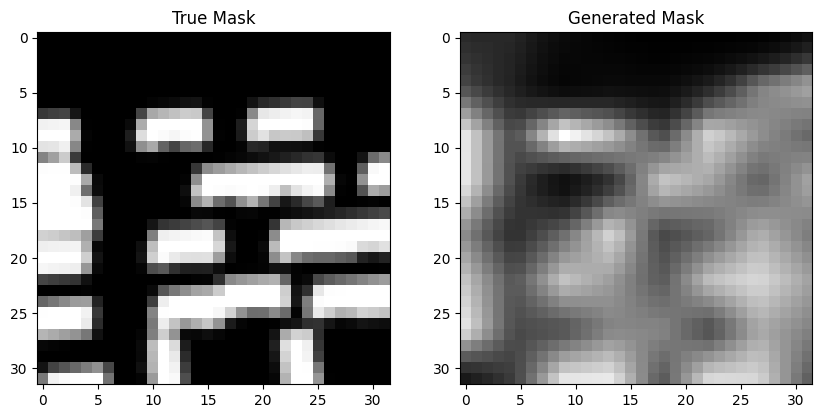

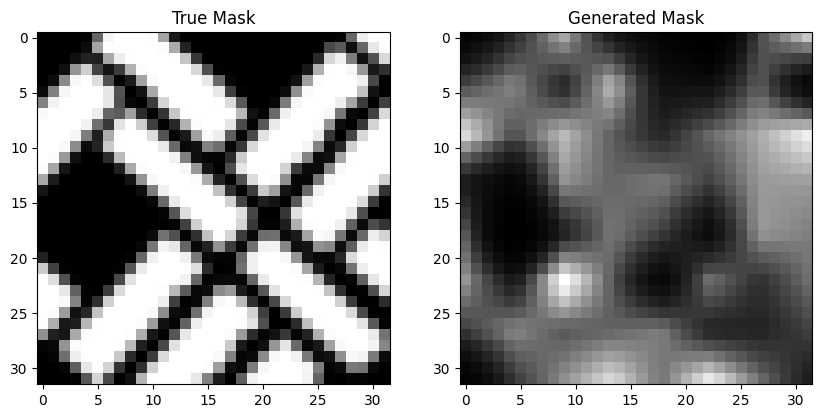

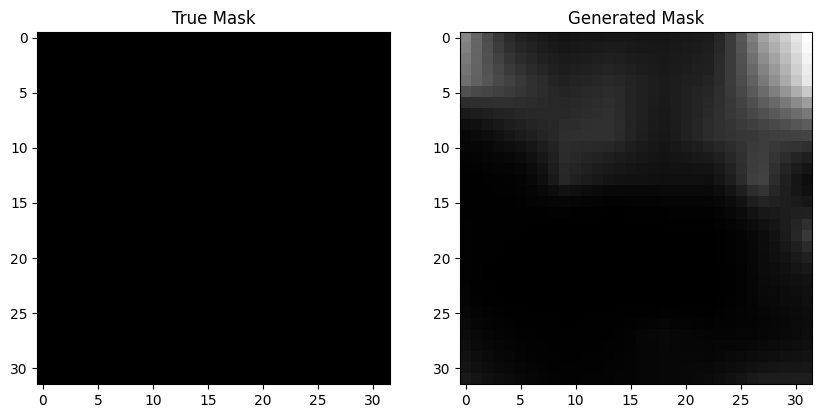

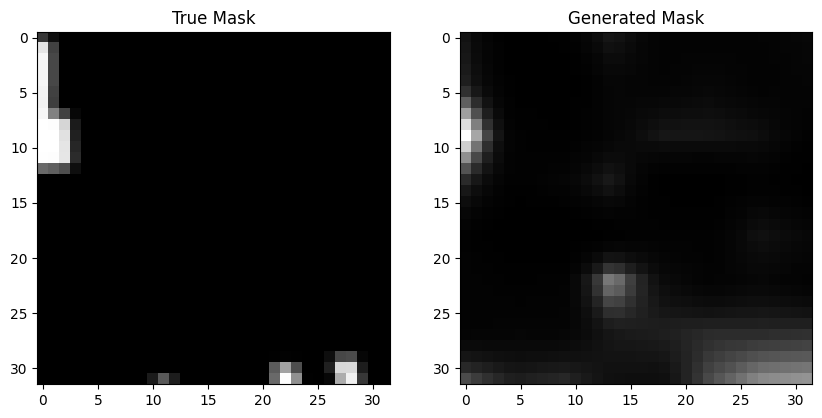

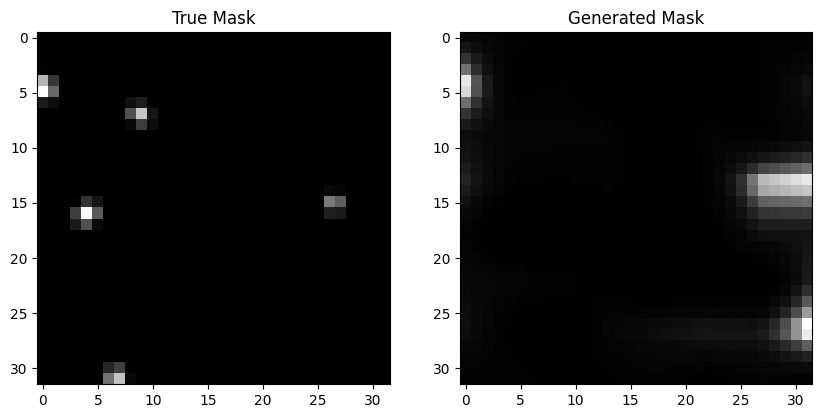

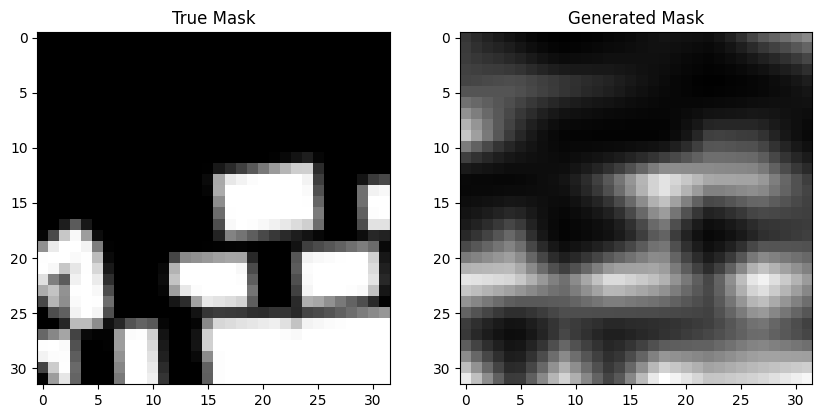

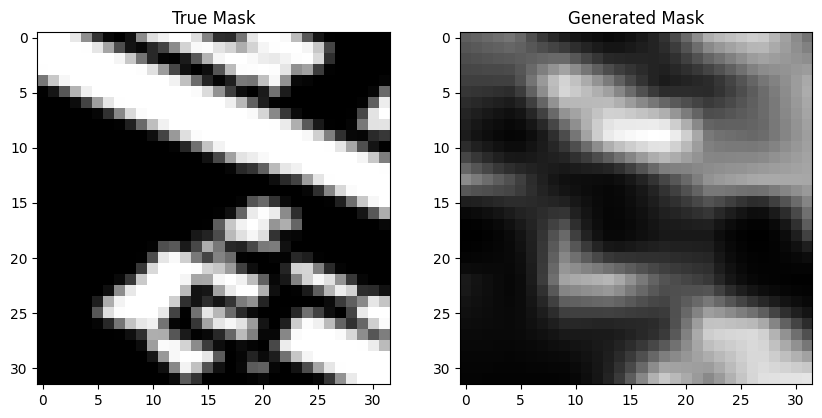

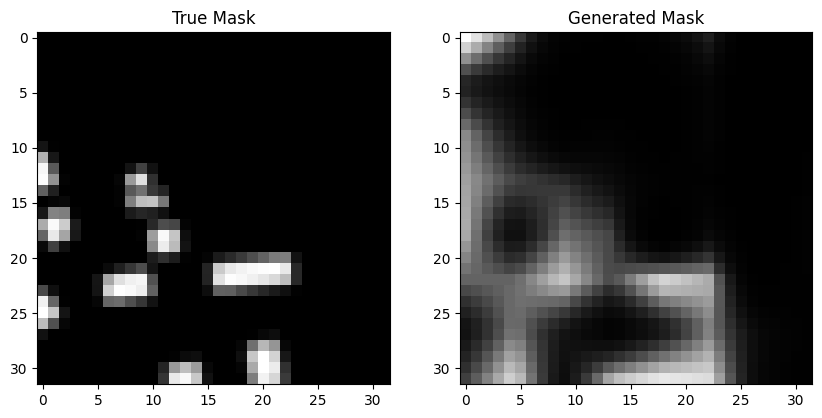

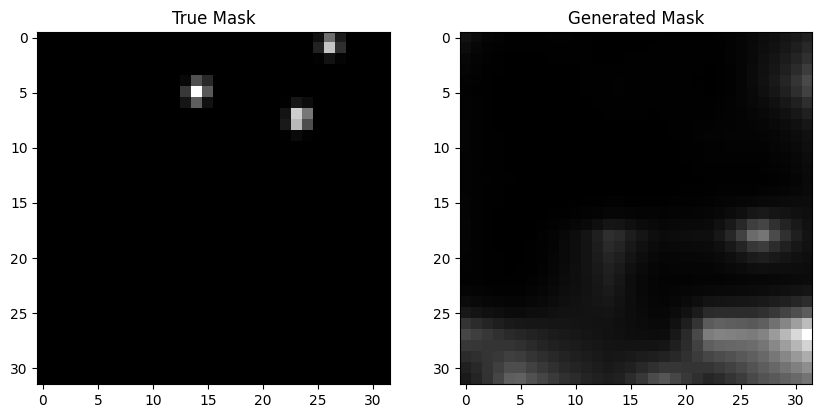

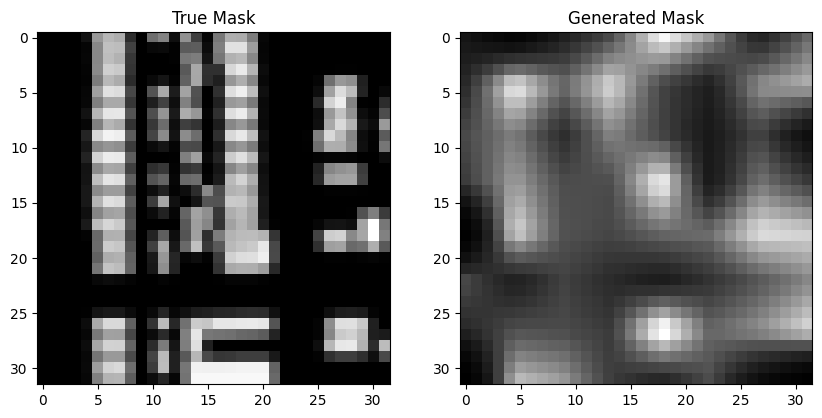

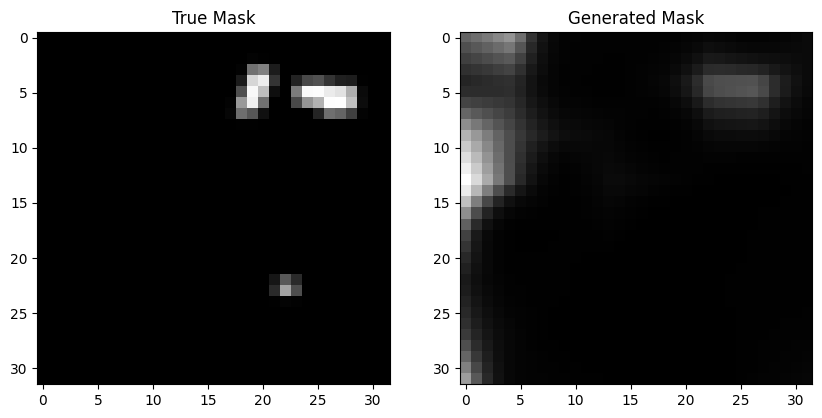

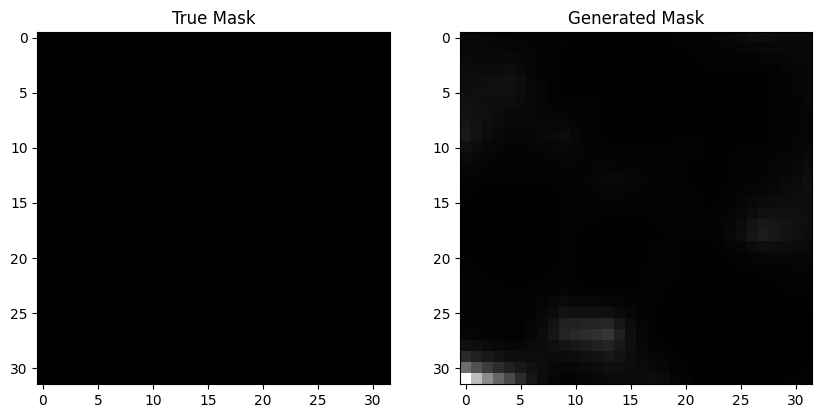

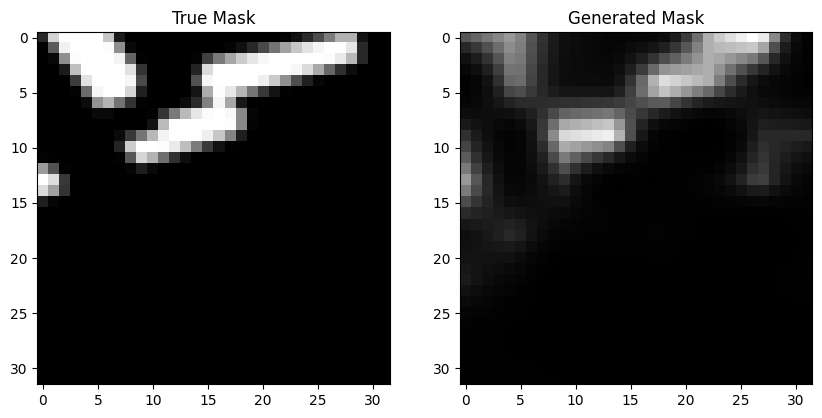

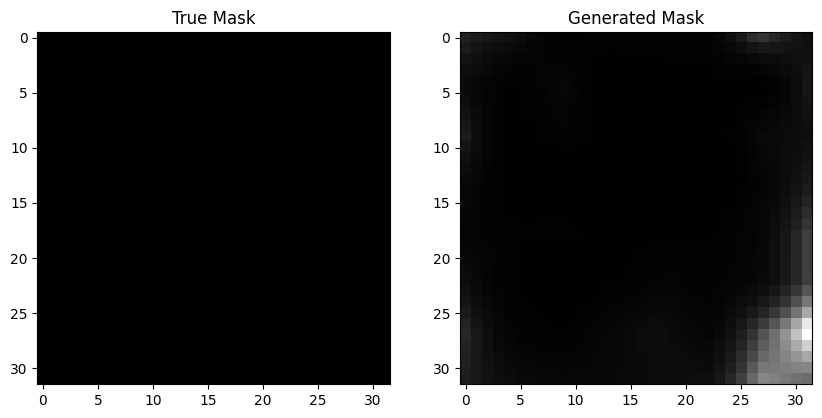

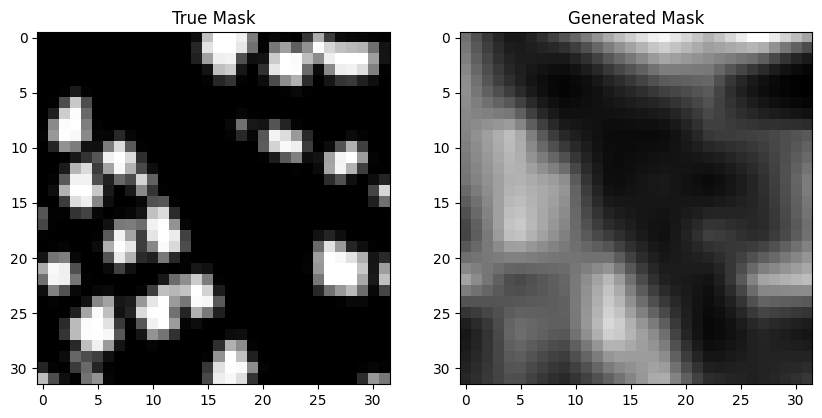

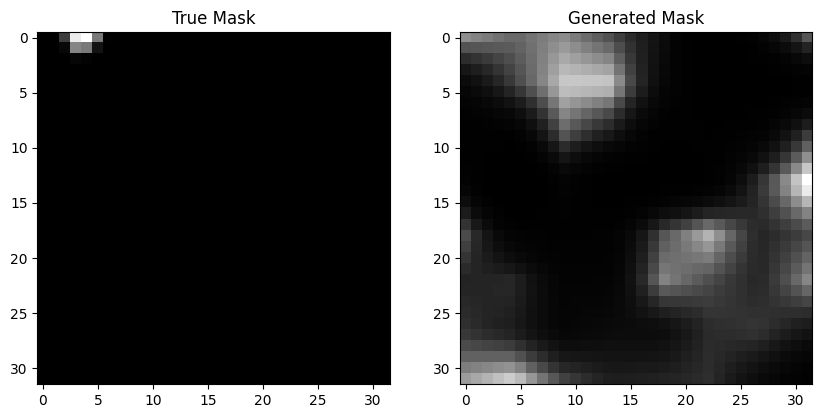

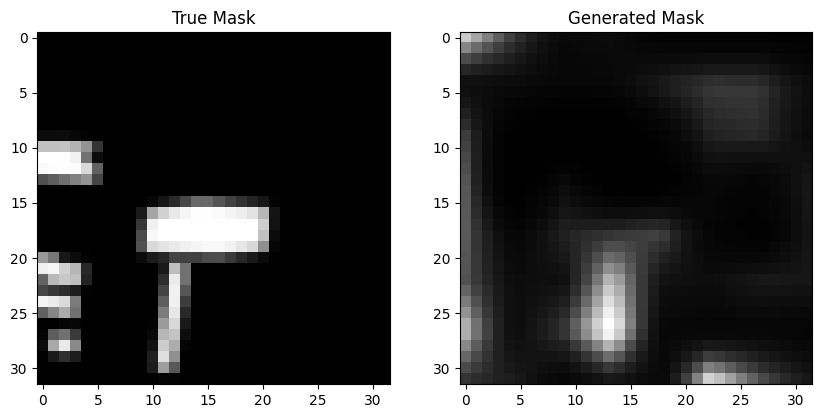

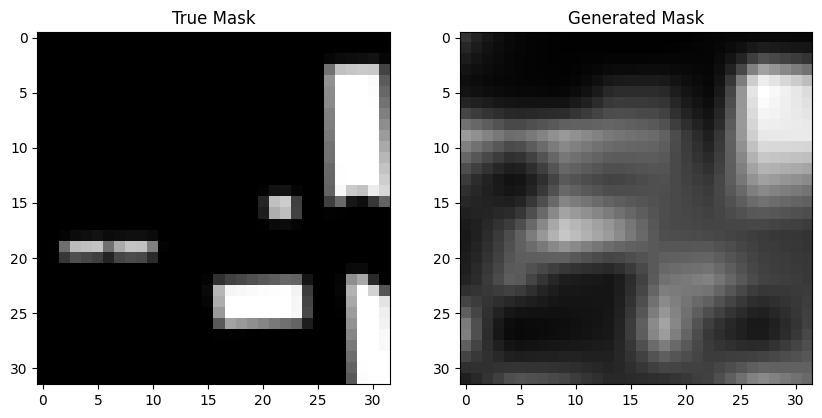

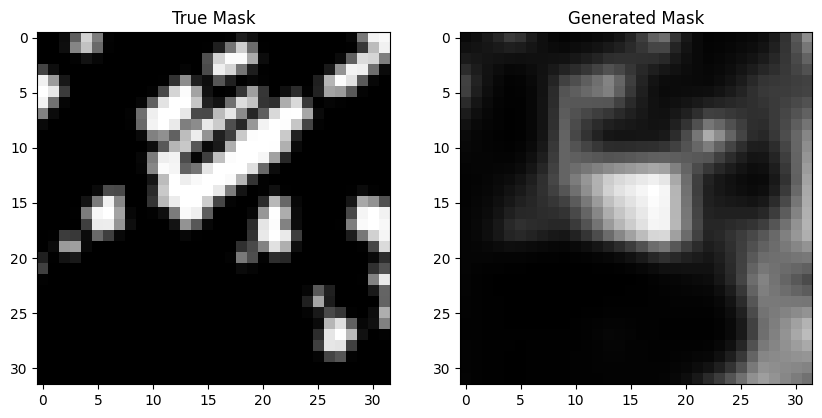

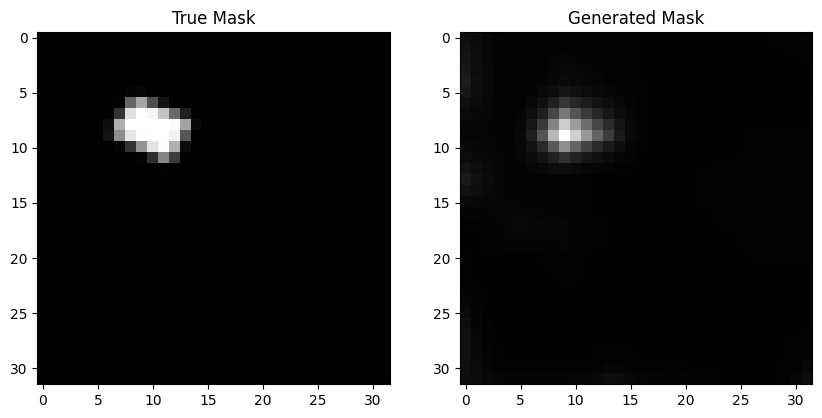

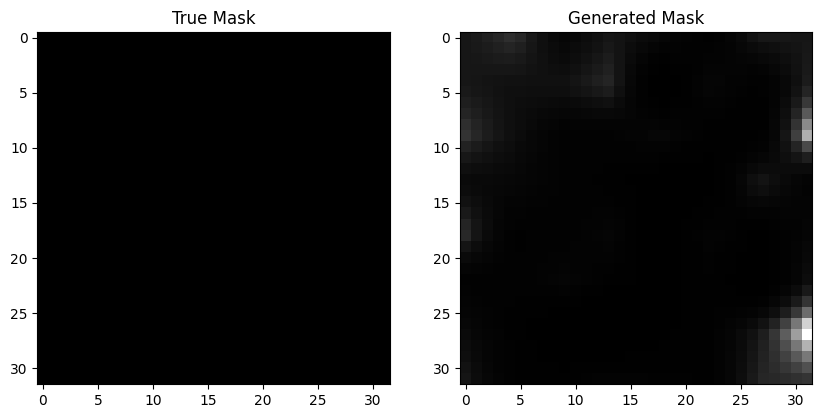

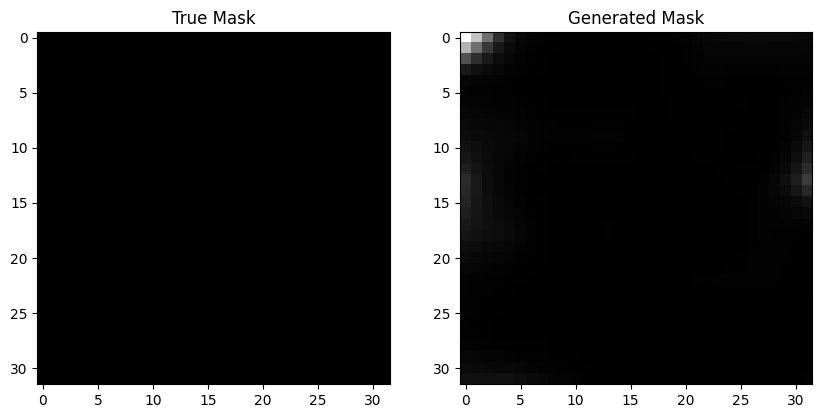

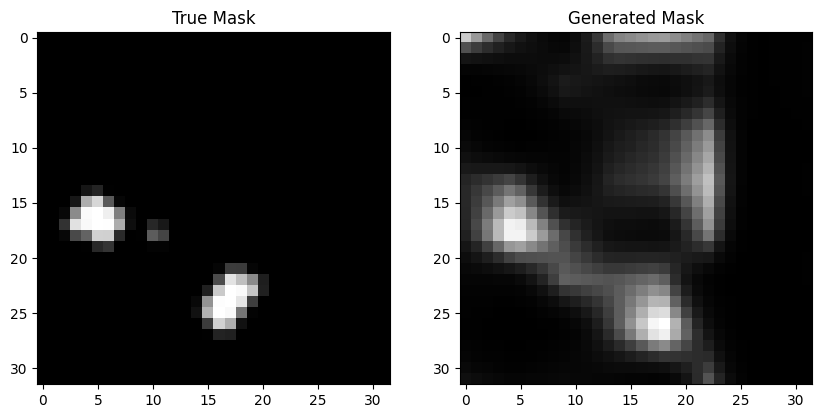

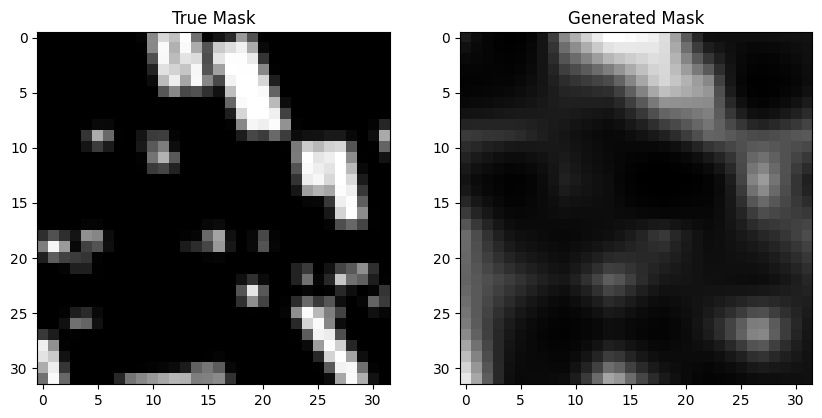

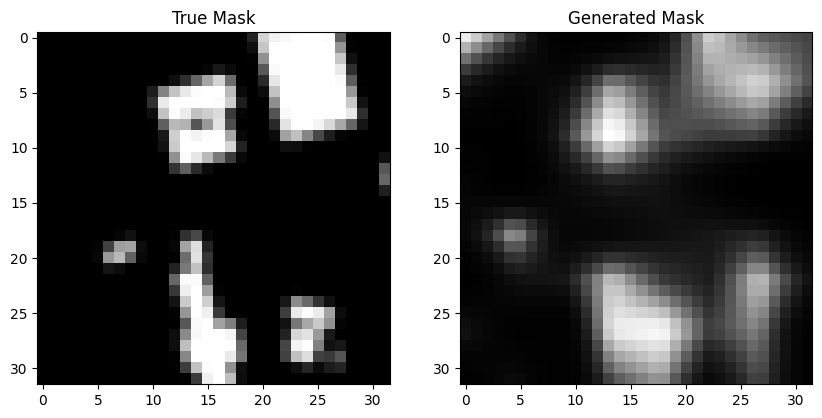

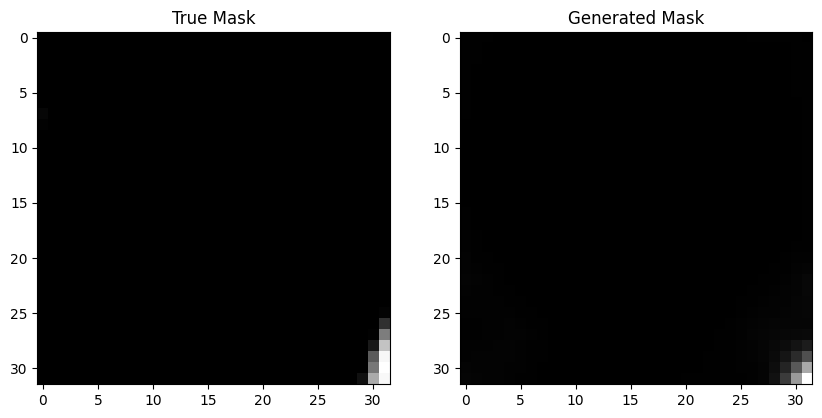

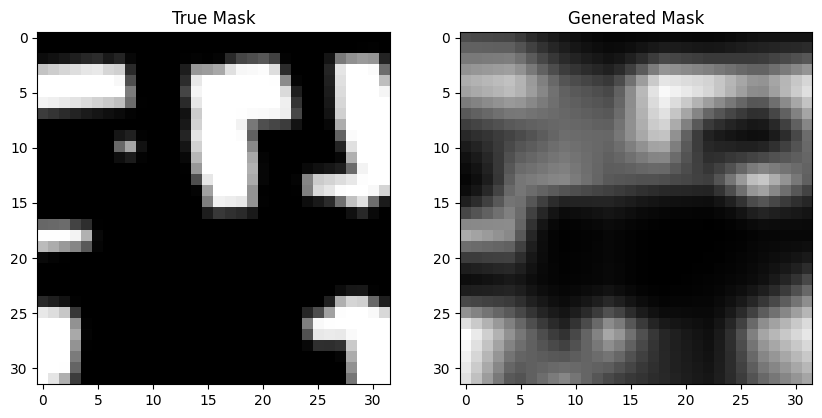

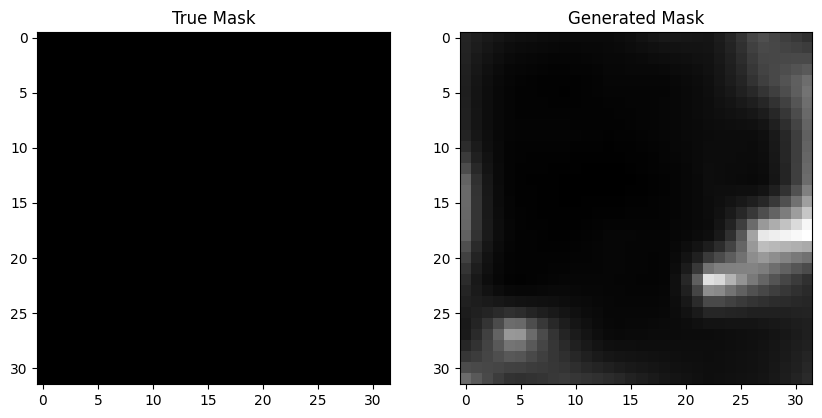

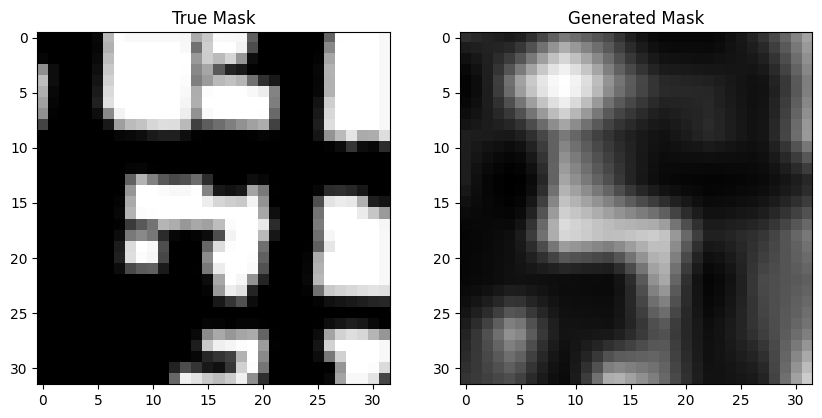

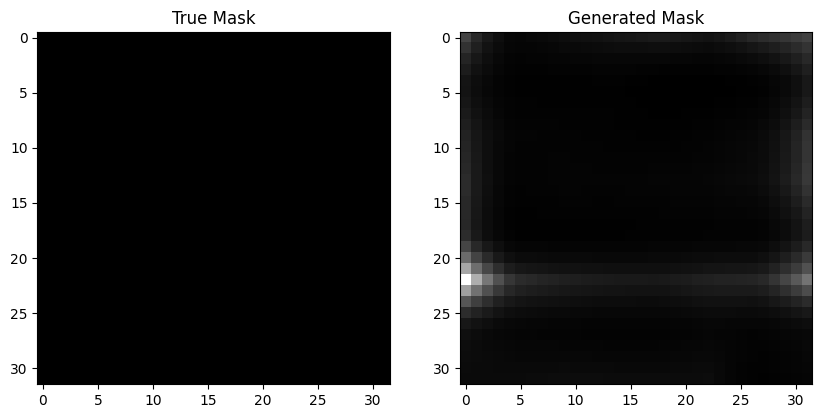

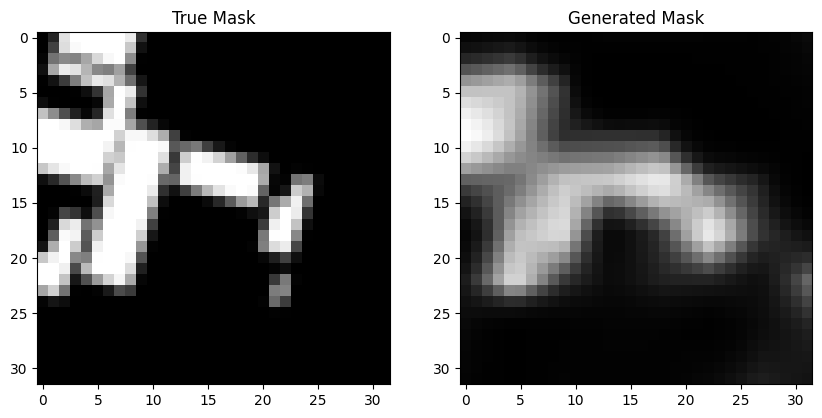

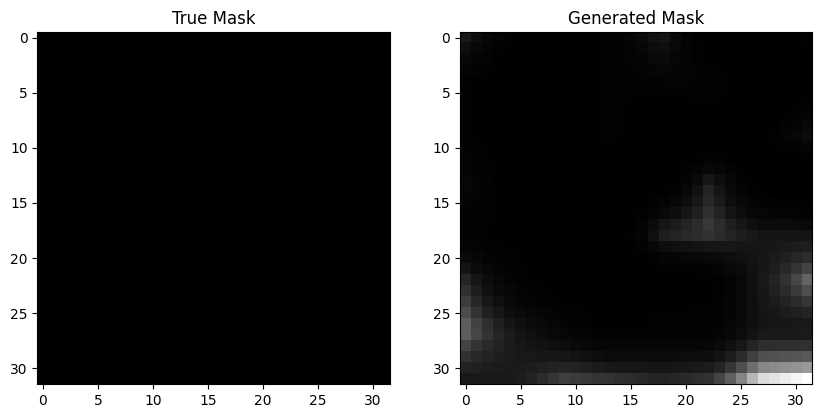

Testing:   3%|▎         | 1/31 [00:05<02:36,  5.20s/batch]

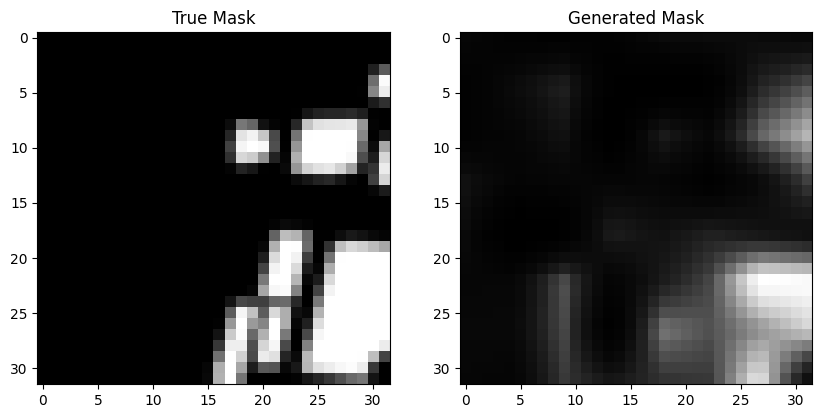

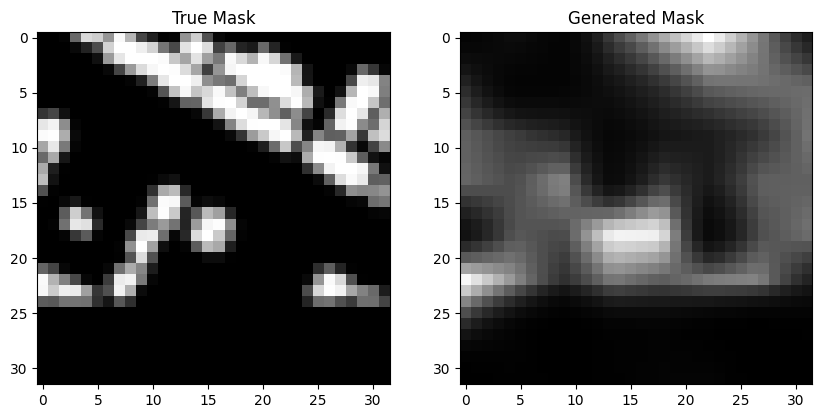

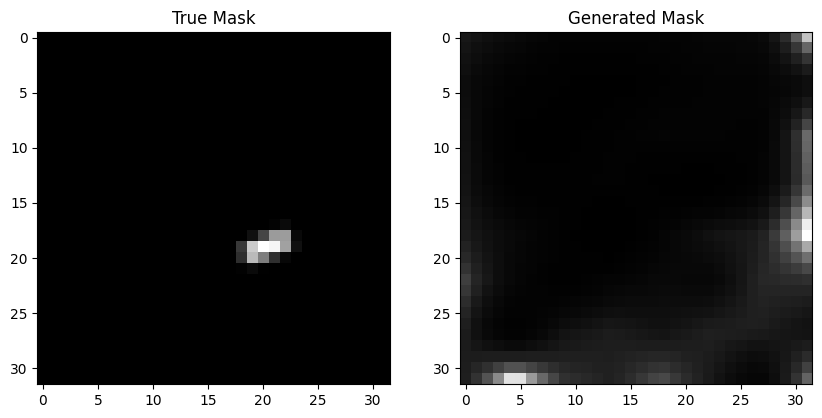

Testing:   3%|▎         | 1/31 [00:06<03:04,  6.16s/batch]


KeyboardInterrupt: 

In [589]:
import matplotlib.pyplot as plt

def test(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    model.to(device)
    
    running_loss = 0.0
    num_samples = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing", unit="batch"):
            # Move data to device
            images, masks = batch["images"].to(device), batch["masks"].to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Calculate loss
            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)  # Multiply by batch size
            
            num_samples += images.size(0)  # Accumulate number of samples
            
            # Convert tensors to numpy arrays
            masks_np = masks.cpu().numpy()
            # outputs_np = torch.argmax(outputs, dim=1).cpu().numpy()
            outputs_np = outputs.cpu().numpy()

            # print(outputs_np.shape, outputs_np1.shape, masks_np.shape)
            # break           
            # Display the true mask and the generated mask
            for i in range(len(images)):
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.title("True Mask")
                plt.imshow(masks_np[i, 0], cmap='gray')
                plt.subplot(1, 2, 2)
                plt.title("Generated Mask")
                plt.imshow(outputs_np[i, 0], cmap='gray')
                plt.show()
        
        # Calculate average loss
        test_loss = running_loss / num_samples
        print(f"Test Loss: {test_loss:.4f}")

# Example usage:
# Assuming you have a test dataset named `test_dataset` and a model named `model`

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_dataset = MyDataset("./dataset/test/", "./dataset/test/_annotations.coco.json")

# Define test loader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Test the model
test(model, test_loader, criterion, device)
